#             <span style= 'color:RED'>      PORTFOLIO OPTIMIZATION

### <span style= 'color:Blue'>Introduction to Portfolio Analysis</span>
Let us understand how portfolio analysis works. Say we have 5 stocks in our portfolio and we want to allocate optimal capital to each of these stocks, such that our risk is minimum. To do this, we need to first create multiple portfolios with different weights reflecting different capital allocations to each stock and calculate the standard deviation of each of the resulting portfolios and then choose the one with the lowest risk.

This is what we will doing in this project.

### <span style= 'color:Blue'> Modern Portfolio Theory </span>

Modern Portfolio Theory or also known as **Mean-Variance analysis** is Markowitz’s theory regarding maximizing the return investors could get in their investment portfolio considering the risk involved in the investments. 

We can reduce the risk by creating a portfolio of different assets and do asset allocation of our investments using a quantitative method.
With a well-balanced and calculated portfolio, if some of the assets fall due to market conditions, others should rise an equal amount in compensation, according to MPT. The beauty of diversification is that you can even get lower risk than a stock with the lowest risk in your portfolio, by optimising the allocation. Markowitz demonstrated that, by taking a portfolio as its whole, it was less volatile than the total sum of its parts.

MPT assumes that investors are risk-averse, meaning that given two portfolios that offer the same expected return, investors will prefer the less risky one. Thus, an investor will take on increased risk only if compensated by higher expected returns.

In [1]:
!pwd

/Users/jasneekchugh/Desktop/DS_NJIT/Fin620/project2


<img src="/img/ss2.jpg"/>

In [2]:
#importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pandas_datareader import data as web
import scipy.optimize as sco
from matplotlib.ticker import FuncFormatter

In [3]:
#Getting the data
stocks = ['AAPL','IBM','AMZN','GOOGL','FB']


stocks_ct = len(stocks)
price_data = []
for ticker in range(stocks_ct):
    prices = web.DataReader(stocks[ticker], start='2010-01-01',data_source='yahoo')
    price_data.append(prices.assign(ticker=ticker)[['Adj Close']]) #we will be taking only 'adj close'
    
df_stocks = pd.concat(price_data, axis=1)
df_stocks.columns=stocks
df_stocks.head()

,AAPL,IBM,AMZN,GOOGL,FB
Date,,,,,
2010-01-04,6.583586,92.528694,133.899994,313.688690,NaN
2010-01-05,6.594968,91.410950,134.690002,312.307312,NaN
2010-01-06,6.490066,90.817116,132.250000,304.434448,NaN
2010-01-07,6.478067,90.502762,130.000000,297.347351,NaN
2010-01-08,6.521136,91.410950,133.520004,301.311310,NaN


In [4]:
df_stocks.tail()

,AAPL,IBM,AMZN,GOOGL,FB
Date,,,,,
2021-03-15,123.989998,128.580002,3081.679932,2054.439941,273.750000
2021-03-16,125.570000,128.240005,3091.860107,2083.889893,279.279999
2021-03-17,124.760002,129.029999,3135.729980,2082.219971,284.010010
2021-03-18,120.529999,130.059998,3027.989990,2021.339966,278.619995
2021-03-19,119.989998,128.899994,3074.959961,2026.959961,290.109985


In [5]:
df_stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2822 entries, 2010-01-04 to 2021-03-19
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    2822 non-null   float64
 1   IBM     2822 non-null   float64
 2   AMZN    2822 non-null   float64
 3   GOOGL   2822 non-null   float64
 4   FB      2223 non-null   float64
dtypes: float64(5)
memory usage: 132.3 KB


In [6]:
#Checking if any NaN values in the data
nullin_df = pd.DataFrame(df_stocks,columns=stocks)
print(nullin_df.isnull().sum())

AAPL       0
IBM        0
AMZN       0
GOOGL      0
FB       599
dtype: int64


There are no NaN values in our data

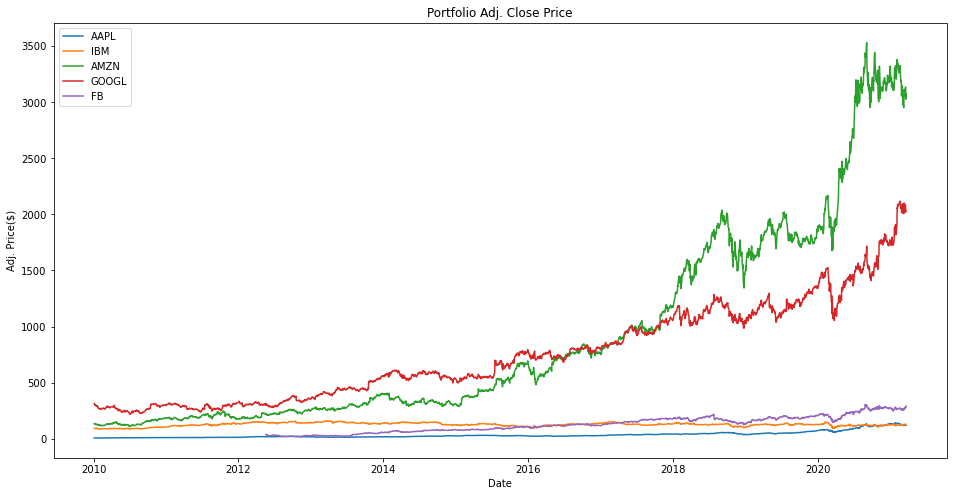

In [7]:
#Create and plot the graph
plt.figure(figsize=(16,8)) 

for c in df_stocks.columns.values:
  plt.plot( df_stocks[c],  label=c)

plt.title("Portfolio Adj. Close Price")
plt.xlabel('Date')
plt.ylabel('Adj. Price($)')
plt.legend(df_stocks.columns.values)
plt.show()

### <span style= 'color:Blue'> Covariance and Correlation </span>

**Covariance** measures the directional relationship between the returns of two assets. The covariance matrix of returns are needed to calculate portfolio returns and volatility. Risk and volatility can be reduced in a portfolio by pairing assets that have a negative covariance.

**Correlation** measure how two assets are related to each other. Correlation is bad; Two stocks that are basically doing the same are not as different as two stocks with vastly different revenue models. 


In [8]:
#Covariance
cov_matrix = df_stocks.pct_change().apply(lambda x: np.log(1+x)).cov()
cov_matrix *252

,AAPL,IBM,AMZN,GOOGL,FB
AAPL,0.080975,0.027192,0.040800,0.039301,0.043308
IBM,0.027192,0.051245,0.024909,0.026699,0.022819
AMZN,0.040800,0.024909,0.099611,0.047436,0.051775
GOOGL,0.039301,0.026699,0.047436,0.067750,0.048076
FB,0.043308,0.022819,0.051775,0.048076,0.137363


In [9]:
#Correlation
corr_matrix = df_stocks.pct_change().apply(lambda x: np.log(1+x)).corr()
corr_matrix

,AAPL,IBM,AMZN,GOOGL,FB
AAPL,1.000000,0.422119,0.454283,0.530608,0.405415
IBM,0.422119,1.000000,0.348642,0.453125,0.262808
AMZN,0.454283,0.348642,1.000000,0.577433,0.462310
GOOGL,0.530608,0.453125,0.577433,1.000000,0.509576
FB,0.405415,0.262808,0.462310,0.509576,1.000000


Once we have the covariance of all the stocks in the portfolio, we need to calculate the standard deviation of the portfolio. To do this, we first need to decide the weights or percentage capital allocation for each stock. 

At first we will give the weights on our own, randomly. But for  optimizing the portfolio, we cannot plug in random weights. We will need to calculate it according to what gives us maximum expected returns.

In [10]:
p_weights = {'AAPL': 0.2, 'NKE': 0.2, 'GOOGL': 0.2, 'MSFT':0.2 ,'AMZN': 0.2}

### <span style= 'color:Blue'> Portfolio Variance </span>
Portfolio variance is a measure of the dispersion of returns of a portfolio. It is the aggregate of the actual returns of a given portfolio over a set period of time. A higher variance will indicate a higher risk for the asset class and the portfolio.

<span style= 'color:orange'>Expected portfolio variance= WT * (Covariance Matrix) * W </span> 

In [11]:
p_var = cov_matrix.mul(p_weights, axis=0).mul(p_weights, axis=1).sum().sum()
p_var

7.990614196379717e-05

### <span style= 'color:Blue'> Portfolio Expected Returns</span>
The expected return of a portfolio is calculated by multiplying the weight of the asset by its return and summing the values of all the assets together. 


In [12]:
# Annualised (Yearly) returns, taking the mean
ind_returns = df_stocks.resample('Y').last().pct_change().mean()
ind_returns

AAPL     0.291988
IBM      0.031087
AMZN     0.349721
GOOGL    0.205978
FB       0.350735
dtype: float64

In [13]:
# Annualised Portfolio returns
wt = [0.2, 0.2, 0.2, 0.2,0.2]
port_er = (wt*ind_returns).sum()
port_er

0.24590181190041155

### <span style= 'color:Blue'> Random Portfolio Generation </span>

Now, we will find the optimal weights of assets and plotting the efficient frontier for our portfolio.

#### Volatility
Volatility is measured as the annual standard deviation of a company’s stock. And to get the annual standard deviation we multiply it by 252 becuase there are 252 trading dayer in a year

In [14]:
annual_std = df_stocks.pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(252))
annual_std

AAPL     0.284561
IBM      0.226374
AMZN     0.315612
GOOGL    0.260288
FB       0.370626
dtype: float64

#### Return and Volatility of Individual Assets

In [15]:
assets = pd.concat([ind_returns, annual_std], axis=1) 
assets.columns = ['Returns', 'Volatility']
assets

,Returns,Volatility
AAPL,0.291988,0.284561
IBM,0.031087,0.226374
AMZN,0.349721,0.315612
GOOGL,0.205978,0.260288
FB,0.350735,0.370626


In [16]:
p_weights = [] 
p_returns = [] 
p_volatility = [] 
num_portfolios = 10000 #Making a 1000 random portfolios
num_assets = len(df_stocks.columns)

In [17]:
for portfolio in range(num_portfolios):
    weights = np.random.random(num_assets) #Taking random weights for each asset
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    returns = np.dot(weights, ind_returns) # weights X Individual Return                               
    p_returns.append(returns)
    var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()# Portfolio Variance
    std = np.sqrt(var) # Daily standard deviation
    annual_std = std*np.sqrt(252) # Annual standard deviation = volatility(Yearly)
    p_volatility.append(annual_std)

In [18]:
data = {'Returns':p_returns, 'Volatility':p_volatility}

for counter, symbol in enumerate(df_stocks.columns.tolist()):
    data[symbol+' Weight'] = [w[counter] for w in p_weights]

In [19]:
portfolios_df  = pd.DataFrame(data)
print(portfolios_df.head())
print(len(portfolios_df))

    Returns  Volatility  AAPL Weight  IBM Weight  AMZN Weight  GOOGL Weight  \
0  0.220537    0.211249     0.357160    0.262875     0.203276      0.172578   
1  0.261255    0.231290     0.196492    0.208651     0.164069      0.076514   
2  0.287386    0.233565     0.280218    0.102449     0.257303      0.095876   
3  0.257674    0.232361     0.273712    0.109940     0.020664      0.288886   
4  0.258887    0.225863     0.344719    0.161659     0.091788      0.136986   

   FB Weight  
0   0.004111  
1   0.354274  
2   0.264155  
3   0.306799  
4   0.264848  
10000


In [20]:
portfolios_df.tail()

,Returns,Volatility,AAPL Weight,IBM Weight,AMZN Weight,GOOGL Weight,FB Weight
9995,0.263672,0.223901,0.196331,0.133389,0.258299,0.225412,0.186569
9996,0.249752,0.221456,0.226270,0.265000,0.218186,0.019082,0.271463
9997,0.240950,0.222921,0.140977,0.112659,0.220910,0.450880,0.074574
9998,0.289664,0.237098,0.160809,0.084843,0.343948,0.166865,0.243535
9999,0.244701,0.225049,0.045212,0.250506,0.269528,0.159103,0.275651


##### So, we made 10000 random porfolios showing return and volatility for each depending upon the weights of assets

#### Simulating Portfolios based on Efficient Frontier

The efficient frontier is the set of **optimal portfolios** that offer the highest expected return for a defined level of risk or the lowest risk for a given level of expected return. Portfolios that lie below the efficient frontier are sub-optimal because they do not provide enough return for the level of risk.

In [21]:
min_vol_port = portfolios_df.iloc[portfolios_df['Volatility'].idxmin()]                           
min_vol_port

Returns         0.151215
Volatility      0.198466
AAPL Weight     0.177513
IBM Weight      0.513136
AMZN Weight     0.069115
GOOGL Weight    0.172692
FB Weight       0.067545
Name: 8293, dtype: float64

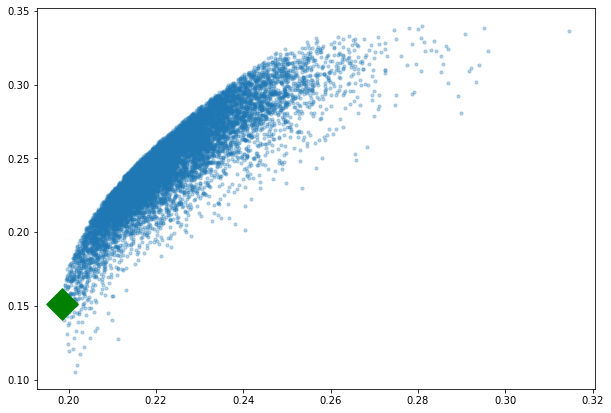

In [22]:
# plotting the minimum volatility portfolio
plt.subplots(figsize=[10,7])
plt.scatter(portfolios_df['Volatility'], portfolios_df['Returns'],marker='o', s=10, alpha=0.3)
plt.scatter(min_vol_port[1], min_vol_port[0], color='g', marker='D', s=500)

The green start shows the portfolio with minimum volatility.

From the plot of the randomly simulated portfolios, we can see it forms a shape of an arch line on the top of clustered blue dots. This line is called efficient frontier. It is efficient because points along the line will give you the lowest risk for a given target return. All the other dots right to the line will give you higher risk with same returns.

Although, we have a portfolio with minimum Volatility but the return on this portfolio is very low. If we want to invest invest we would want to have som good amaount of return as well, keeping volatility in mind.  

### <span style= 'color:Blue'> Optimal Risky Portfolio </span>

### Sharpe Ratio

Sharpe ration is used for expressing risk-adjusted return. Risk-adjusted return refines an investment’s return by measuring how much risk is involved in producing that return.

The Sharpe ratio describes how much excess return you are receiving for the extra volatility that you endure for holding a riskier asset. 

 *** Sharpe Ratio = (Rx – Rf) / StdDev Rx ***
 
Where:

- Rx = Expected portfolio return
- Rf = Risk-free rate of return
- StdDev Rx = Standard deviation of portfolio return (or, volatility)

![](/Users/jasneekchugh/Desktop/DS_NJIT/Fin620/ss2.jpg)

In [23]:
risk_factor = 0.016
optimal_risky_port = portfolios_df.iloc[((portfolios_df['Returns']-risk_factor)/portfolios_df['Volatility']).idxmax()]
optimal_risky_port

Returns         0.324205
Volatility      0.249496
AAPL Weight     0.338019
IBM Weight      0.005717
AMZN Weight     0.379807
GOOGL Weight    0.030809
FB Weight       0.245648
Name: 6369, dtype: float64

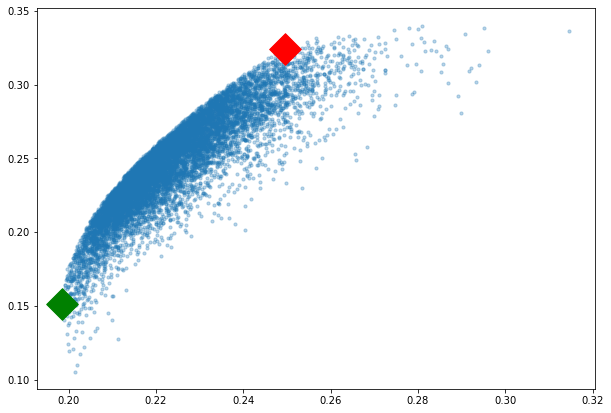

In [24]:
# Plotting optimal portfolio
plt.subplots(figsize=(10, 7))
plt.scatter(portfolios_df['Volatility'], portfolios_df['Returns'],marker='o', s=10, alpha=0.3)
plt.scatter(min_vol_port[1], min_vol_port[0], color='g', marker='D', s=500)
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='r', marker='D', s=500)

**So, if we compare the difference in risk between minimum volatility portfolio and optimal risky portfolio is just 5%, the difference in returns is 18%. ***

### <span style= 'color:Blue'> Conclusion </span>

I was pretty new to this portfolio analysis and how to optimize a one. But I had fun going through coding and trying to understand the concept. I try to follow all the part individually first, just to understand all the steps and what get returned at each step by hardcoding the values of weights, that is, 0.2 to each asset. Later, i randomly assigned weights to each asset and created a for loop which had all the necessary calculation that was needed to get the portfolio with minimum volatility. 

Also, using Sharpe ratio we saw the excess return we can receiving for some extra volatility.

### <span style= 'color:Blue'> Further Analysis </span>

There are more techniques in market that are used for portfolio optimization.Also, i find out we can automate the Portfolio Optimization and Allocation using a python library "PyPortfolioOpt". I would like to explore and perform the same analysis using the PyPortfolioOpt library to see the difference in results, if any. 